In [1]:
# 🎮 安装所需依赖
!pip install torch deepctr-torch pandas numpy scikit-learn flask requests pyngrok matplotlib

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 111.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.8/400.8 kB 111.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: pip install 

In [2]:
import pandas as pd
import numpy as np
import ast
import torch
import random
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.inputs import SparseFeat, DenseFeat, VarLenSparseFeat
from deepctr_torch.models import DeepFM
import matplotlib.pyplot as plt
from deepctr_torch.callbacks import EarlyStopping
import torch.optim as optim

# ==========================================
# ⚙️ 全局配置中心 (Global Config)
# ==========================================
class SteamConfig:
    # 1. 数据路径
    CSV_PATH = '../data/steam/deepfm_train_100k.csv' # 你的训练文件路径
    MODEL_PATH = 'deepfm_steam_weights.pth'          # 模型保存路径
    
    # 2. 特征参数
    MAX_TAG_LEN = 5          # 每个游戏最多取多少个 Tag
    EMBEDDING_DIM = 32       # 词向量维度 (建议 32 或 64)
    
    # 3. 网络结构
    # 建议不要太大，推荐 (256, 128) 或 (128, 128)
    DNN_HIDDEN_UNITS = (128, 64) 
    DNN_DROPOUT = 0.5
    
    # 4. 训练参数
    BATCH_SIZE = 256
    EPOCHS = 20              # 20轮一般就够了
    LEARNING_RATE = 0.001    # Adam 默认值，通常不用改
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 2025
    
# 实例化配置
cfg = SteamConfig()
print(f"🔥 当前配置 -> 设备: {cfg.DEVICE} | 网络结构: {cfg.DNN_HIDDEN_UNITS}")


# --- 固定随机种子 (保证结果可复现) ---
def seed_everything(seed=2024):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(cfg.SEED)

# --- 序列补齐函数 ---
def pad_sequences(sequences, maxlen, value=0):
    """把变长的 Tag 列表补齐为定长"""
    result = np.full((len(sequences), maxlen), value, dtype=np.int32)
    for i, seq in enumerate(sequences):
        if len(seq) > 0:
            trunc = seq[:maxlen]
            result[i, :len(trunc)] = trunc
    return result

2025-12-16 16:55:57.909320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 16:55:57.957371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 16:55:59.692643: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


🔥 当前配置 -> 设备: cuda | 网络结构: (128, 64)


## Steam 数据加载与预处理

根据 Config 自动调整词表大小和特征维度。

核心逻辑：

1. 处理 tags_list: 它是字符串格式的列表 "[1663, 1774]"，需要还原并补齐长度。

2. 处理 price: 归一化。

3. 处理 item_id: 建立索引映射。

In [3]:
def load_steam_data(csv_path, config):
    print(f"📂 正在加载数据: {csv_path} ...")
    data = pd.read_csv(csv_path)
    
    # 1. Tags 处理
    data['tags_list'] = data['tags_list'].apply(lambda x: ast.literal_eval(x))
    all_tags = [tag for sublist in data['tags_list'] for tag in sublist]
    tag_lbe = LabelEncoder()
    tag_lbe.fit(all_tags)
    max_tag_id = len(tag_lbe.classes_) + 1
    data['tags_list'] = data['tags_list'].apply(lambda x: [i+1 for i in tag_lbe.transform(x)] if len(x)>0 else [])
    
    # 2. ItemID 处理
    item_lbe = LabelEncoder()
    data['item_id_idx'] = item_lbe.fit_transform(data['item_id'])
    max_item_id = data['item_id_idx'].max() + 1
    
    # 3. UserType 处理 (🔥 新增)
    user_lbe = LabelEncoder()
    data['user_type_idx'] = user_lbe.fit_transform(data['user_type'])
    max_user_type_id = data['user_type_idx'].max() + 1
    print(f"🔥 识别到玩家类型: {list(user_lbe.classes_)}")
    
    # 4. Price 处理
    mms = MinMaxScaler(feature_range=(0, 1))
    data['price_norm'] = mms.fit_transform(data[['price']])
    
    # 5. 定义特征列
    tags_padded = pad_sequences(list(data['tags_list']), maxlen=config.MAX_TAG_LEN, value=0)
    
    fixlen_feature_columns = [
        SparseFeat('item_id_idx', vocabulary_size=max_item_id, embedding_dim=config.EMBEDDING_DIM),
        # 🔥 把 UserType 加入特征列
        SparseFeat('user_type_idx', vocabulary_size=max_user_type_id, embedding_dim=config.EMBEDDING_DIM),
        DenseFeat('price_norm', dimension=1)
    ]
    
    varlen_feature_columns = [
        VarLenSparseFeat(
            SparseFeat('tags', vocabulary_size=max_tag_id, embedding_dim=config.EMBEDDING_DIM),
            maxlen=config.MAX_TAG_LEN, combiner='mean', length_name=None
        )
    ]
    
    linear_cols = fixlen_feature_columns + varlen_feature_columns
    dnn_cols = fixlen_feature_columns + varlen_feature_columns
    
    # 6. 组装输入
    model_input = {
        'item_id_idx': data['item_id_idx'].values,
        'user_type_idx': data['user_type_idx'].values, # 🔥 数据里也要加上
        'price_norm': data['price_norm'].values,
        'tags': tags_padded
    }
    
    # 多返回一个 user_lbe，给 Cell 5 用
    return model_input, linear_cols, dnn_cols, data['label'].values, data, user_lbe

## Steam 模型训练 (Training)

📂 正在加载数据: ../data/steam/deepfm_train_100k.csv ...
🔥 识别到玩家类型: ['Anime_Weeb', 'Casual_Relax', 'Coop_Player', 'Free_Loader', 'Hardcore_FPS', 'Horror_Fan', 'Indie_Hipster', 'Puzzle_Solver', 'RPG_Story', 'Rich_Collector', 'SciFi_Geek', 'Souls_Veteran', 'Sports_Racer', 'Strategy_Brain', 'Trend_Follower']
🔧 初始化模型: (128, 64), Dropout: 0.5
🚀 开始训练 (Epochs: 20, Batch: 256)...
cuda
Train on 63541 samples, validate on 15886 samples, 249 steps per epoch
Epoch 1/20
2s - loss:  0.6228 - binary_crossentropy:  0.6223 - auc:  0.6995 - val_binary_crossentropy:  0.5801 - val_auc:  0.7409
Epoch 2/20
1s - loss:  0.5464 - binary_crossentropy:  0.5462 - auc:  0.7747 - val_binary_crossentropy:  0.5137 - val_auc:  0.8099
Epoch 3/20
1s - loss:  0.4676 - binary_crossentropy:  0.4678 - auc:  0.8481 - val_binary_crossentropy:  0.4697 - val_auc:  0.8482
Epoch 4/20
1s - loss:  0.4230 - binary_crossentropy:  0.4228 - auc:  0.8790 - val_binary_crossentropy:  0.4368 - val_auc:  0.8709
Epoch 5/20
1s - loss:  0.3813 - bina

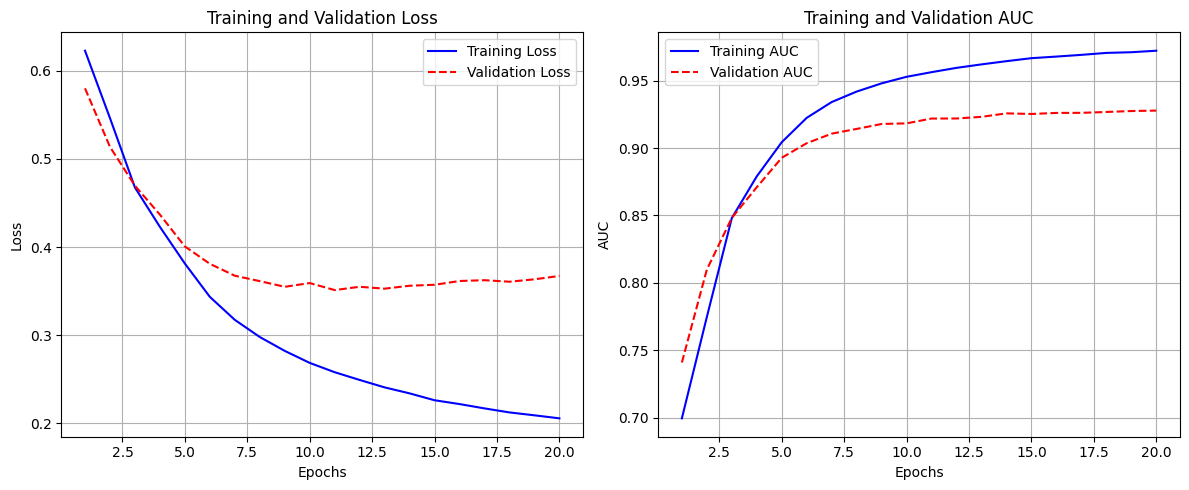

In [4]:
# 1. 加载数据 
# (保持之前的修正：接收 6 个参数，忽略最后两个)
input_dict, linear_cols, dnn_cols, target, _, _ = load_steam_data(cfg.CSV_PATH, cfg)

# 2. 初始化 DeepFM
print(f"🔧 初始化模型: {cfg.DNN_HIDDEN_UNITS}, Dropout: {cfg.DNN_DROPOUT}")
model = DeepFM(linear_feature_columns=linear_cols, 
               dnn_feature_columns=dnn_cols, 
               task='binary', 
               dnn_hidden_units=cfg.DNN_HIDDEN_UNITS, 
               dnn_dropout=cfg.DNN_DROPOUT,
               device=cfg.DEVICE)

model.compile(optimizer=optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE), 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", "auc"])

# ==========================================
# 📈 绘制 Loss 曲线 (已修复 KeyError)
# ==========================================
def plot_learning_curves(history):
    # 打印所有可用的键，方便调试
    print(f"Available keys in history: {history.history.keys()}")
    
    # 1. 安全获取 Loss
    loss = history.history['loss']
    # 核心修复：优先找 'val_loss'，找不到就找 'val_binary_crossentropy'
    val_loss = history.history.get('val_loss', history.history.get('val_binary_crossentropy'))
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # --- 子图 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # --- 子图 2: AUC ---
    if 'auc' in history.history:
        auc = history.history['auc']
        # 同样安全获取 val_auc
        val_auc = history.history.get('val_auc', None)
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, auc, 'b-', label='Training AUC')
        if val_auc is not None:
            plt.plot(epochs, val_auc, 'r--', label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

# --- 3. 定义 Early Stopping 回调 ---
# monitor='val_auc': 监控验证集的 AUC
# patience=2: 如果连续 2 轮 AUC 都没有提升，就立刻停止训练
# mode='max': AUC 越大越好
es = EarlyStopping(monitor='val_auc', min_delta=0, patience=2, mode='max')

# 4. 训练
print(f"🚀 开始训练 (Epochs: {cfg.EPOCHS}, Batch: {cfg.BATCH_SIZE})...")
history = model.fit(input_dict, target, 
                    batch_size=cfg.BATCH_SIZE, 
                    epochs=cfg.EPOCHS, 
                    verbose=2, 
                    validation_split=0.2,
                    callbacks=[es])

# 5. 保存模型
torch.save(model.state_dict(), cfg.MODEL_PATH)
print(f"✅ 模型权重已保存至: {cfg.MODEL_PATH}")

# 6. 画图
print("\n📊 正在生成训练曲线...")
plot_learning_curves(history)

## 加载权重并启动 API 服务 (Loading & Serving)

In [5]:
import torch
import pandas as pd
import numpy as np
import threading
from flask import Flask, request, jsonify
from deepctr_torch.models import DeepFM

# 1. 准备环境 (注意接收 user_lbe)
print("🔄 正在初始化服务...")
# 🔥 这里接收 user_lbe
_, linear_cols, dnn_cols, _, df_raw, user_lbe = load_steam_data(cfg.CSV_PATH, cfg)

# 2. 初始化模型
service_model = DeepFM(linear_feature_columns=linear_cols, 
                       dnn_feature_columns=dnn_cols, 
                       task='binary', 
                       dnn_hidden_units=cfg.DNN_HIDDEN_UNITS, 
                       dnn_dropout=cfg.DNN_DROPOUT,
                       device=cfg.DEVICE)

# 3. 加载权重
try:
    service_model.load_state_dict(torch.load(cfg.MODEL_PATH, map_location=cfg.DEVICE))
    service_model.eval()
    print("✅ 模型权重加载成功！")
except FileNotFoundError:
    print(f"❌ 未找到权重文件 {cfg.MODEL_PATH}")

# ================= 搭建 Flask API =================
app = Flask(__name__)

@app.route('/recommend', methods=['POST'])
def recommend_api():
    try:
        req = request.json
        top_k = req.get('top_k', 3)
        # 获取请求里的 type，默认为 Hardcore_FPS
        user_type_str = req.get('type', 'Hardcore_FPS')
        
        # 🔥 1. 类型转 ID
        if user_type_str not in user_lbe.classes_:
            return jsonify({"error": f"未知类型: {user_type_str}. 支持: {list(user_lbe.classes_)}"}), 400
        
        # 拿到数字 ID
        user_type_id = user_lbe.transform([user_type_str])[0]
        print(f"🎮 请求: {user_type_str} (ID={user_type_id})")

        # 🔥 2. 构造个性化输入
        # 我们要预测这个特定用户对库里所有游戏的评分
        # 所以构造一个全长的数组，全填这个用户的 ID
        num_items = len(df_raw)
        user_type_col = np.full(num_items, user_type_id)

        tags_padded = pad_sequences(list(df_raw['tags_list']), maxlen=cfg.MAX_TAG_LEN, value=0)
        
        input_dict = {
            'item_id_idx': df_raw['item_id_idx'].values,
            'user_type_idx': user_type_col, # 🔥 全量填入指定用户ID
            'price_norm': df_raw['price_norm'].values,
            'tags': tags_padded
        }
        
        # 3. 预测
        with torch.no_grad():
            pred_scores = service_model.predict(input_dict, batch_size=4096)
            
        # 4. 排序 + 去重
        temp_df = df_raw.copy()
        temp_df['score'] = pred_scores
        
        top_items = temp_df.sort_values(by='score', ascending=False) \
                           .drop_duplicates(subset=['item_id']) \
                           .head(top_k)
        
        # 5. 格式化
        results = []
        for _, row in top_items.iterrows():
            results.append({
                "id": str(row['item_id']),
                "title": row['title'],
                "score": float(row['score']),
                "tags": row.get('tag_names', 'Unknown'),
                "cover": row.get('cover_url', '')
            })
            
        return jsonify({
            "code": 200, 
            "type": user_type_str, 
            "data": results
        })
        
    except Exception as e:
        return jsonify({"code": 500, "error": str(e)})

# ================= 启动线程 =================
def run_flask():
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

if 'flask_thread' not in locals() or not flask_thread.is_alive():
    flask_thread = threading.Thread(target=run_flask)
    flask_thread.daemon = True
    flask_thread.start()
    print("🚀 服务已更新并启动！")
else:
    print("⚠️ 服务线程已存在，请尝试重启 Kernel 以应用新代码。")

🔄 正在初始化服务...
📂 正在加载数据: ../data/steam/deepfm_train_100k.csv ...
🔥 识别到玩家类型: ['Anime_Weeb', 'Casual_Relax', 'Coop_Player', 'Free_Loader', 'Hardcore_FPS', 'Horror_Fan', 'Indie_Hipster', 'Puzzle_Solver', 'RPG_Story', 'Rich_Collector', 'SciFi_Geek', 'Souls_Veteran', 'Sports_Racer', 'Strategy_Brain', 'Trend_Follower']
✅ 模型权重加载成功！
🚀 服务已更新并启动！


## 测试服务 (Client Test)

In [ ]:
import requests
import time

# 确保服务已启动
time.sleep(1)
url = "http://127.0.0.1:5000/recommend"

# 1. 获取所有支持的类型
# user_lbe 是在 Cell 3 或 Cell 5 运行后生成的
try:
    all_types = list(user_lbe.classes_)
    print(f"📋 准备测试以下玩家类型: {all_types}")
except NameError:
    print("⚠️ 警告: 未找到 user_lbe 变量。请确保你运行了前面的 Cell。")
    # 如果找不到，手动指定几个试试
    all_types = ["Hardcore_FPS", "Casual_Gamer", "RPG_Player"] 

print("="*40)

# 2. 循环发送请求
for u_type in all_types:
    print(f"\n📡 发送请求 -> 玩家类型: 【{u_type}】")
    
    payload = {
        "type": u_type, 
        "top_k": 5
    }

    try:
        # 发送 POST 请求
        resp = requests.post(url, json=payload, timeout=5)
        
        if resp.status_code == 200:
            res_json = resp.json()
            data = res_json.get('data', [])
            
            print(f"✅ 推荐成功 (Top {len(data)}):")
            for item in data:
                # 打印分数、标题和标签，方便对比不同人群的喜好
                print(f"  - [{item['score']:.4f}] {item['title']} \n    🏷️ Tags: {item['tags']}")
        else:
            print(f"❌ 请求失败: {resp.text}")
            
    except Exception as e:
        print(f"❌ 连接错误: {e}")
    
    # 稍微停顿一下，防止刷屏太快
    time.sleep(0.5)

print("\n" + "="*40)
print("🏁 测试结束！请观察不同类型的推荐结果是否有区分度。")

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.224.186.252:5000
Press CTRL+C to quit


📋 准备测试以下玩家类型: ['Anime_Weeb', 'Casual_Relax', 'Coop_Player', 'Free_Loader', 'Hardcore_FPS', 'Horror_Fan', 'Indie_Hipster', 'Puzzle_Solver', 'RPG_Story', 'Rich_Collector', 'SciFi_Geek', 'Souls_Veteran', 'Sports_Racer', 'Strategy_Brain', 'Trend_Follower']

📡 发送请求 -> 玩家类型: 【Anime_Weeb】
🎮 请求: Anime_Weeb (ID=0)


127.0.0.1 - - [16/Dec/2025 16:57:03] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] Monster Hunter Wilds - 追加猎人外观装备“霹雳舞猫系列” 
    🏷️ Tags: 动作,冒险,RPG
  - [1.0000] ARK Fantastic Tames - Pyromane 
    🏷️ Tags: 动作,冒险,RPG
  - [1.0000] 隐形守护者 The Invisible Guardian - 6至10章,终章 
    🏷️ Tags: RPG,冒险,独立
  - [1.0000] Kingdom Come: Deliverance – Treasures of The Past 
    🏷️ Tags: RPG,冒险,动作
  - [0.9999] Assassin's Creed® Valhalla - Dawn of Ragnarök 
    🏷️ Tags: 动作,冒险,RPG

📡 发送请求 -> 玩家类型: 【Casual_Relax】
🎮 请求: Casual_Relax (ID=1)


127.0.0.1 - - [16/Dec/2025 16:57:04] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] The Planet Crafter - Planet Humble 
    🏷️ Tags: 冒险,模拟,沙盒
  - [1.0000] This War of Mine: The Little Ones 
    🏷️ Tags: 策略,独立,冒险
  - [1.0000] Don't Starve: Hamlet 
    🏷️ Tags: 冒险,独立,策略
  - [1.0000] Operation: Tango 
    🏷️ Tags: 解谜,沙盒,冒险
  - [0.9999] Wilmot Works It Out 
    🏷️ Tags: 解谜,休闲,单人

📡 发送请求 -> 玩家类型: 【Coop_Player】
🎮 请求: Coop_Player (ID=2)


127.0.0.1 - - [16/Dec/2025 16:57:05] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] 一步一脚印 
    🏷️ Tags: 动作,冒险,休闲
  - [1.0000] SpongeBob SquarePants: Battle for Bikini Bottom - Rehydrated 
    🏷️ Tags: 冒险,多人,动作
  - [1.0000] 咩咩启示录：异教徒包 
    🏷️ Tags: 冒险,动作,独立
  - [1.0000] 滴答：双人冒险 
    🏷️ Tags: 解谜,沙盒,冒险
  - [1.0000] FRAMED Collection 
    🏷️ Tags: 解谜,独立,休闲

📡 发送请求 -> 玩家类型: 【Free_Loader】
🎮 请求: Free_Loader (ID=3)


127.0.0.1 - - [16/Dec/2025 16:57:06] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [0.9954] 远光84 
    🏷️ Tags: 免费开玩,多人,射击
  - [0.9953] Warface: Clutch 
    🏷️ Tags: 免费开玩,类Rogue,多人
  - [0.9941] 凡人修仙传奇 
    🏷️ Tags: 免费开玩
  - [0.9939] 命运2 
    🏷️ Tags: 免费开玩,开放世界,多人
  - [0.9938] Strinova 
    🏷️ Tags: 免费开玩,像素风,类Rogue

📡 发送请求 -> 玩家类型: 【Hardcore_FPS】
🎮 请求: Hardcore_FPS (ID=4)


127.0.0.1 - - [16/Dec/2025 16:57:07] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] 《使命召唤®：现代战争® III 2023》 婚礼噩梦终极外观精英曳光包 
    🏷️ Tags: 类Rogue,多人,动作
  - [1.0000] 第 1 赛季战地 Pro——《战地风云™ 6》和禁区冲突 
    🏷️ Tags: 动作,类Rogue,多人
  - [1.0000] Strange Brigade 
    🏷️ Tags: 动作,冒险,沙盒
  - [1.0000] 狙击精英：抵抗 
    🏷️ Tags: 动作,冒险,单人
  - [1.0000] Zombie Army 4: Dead War 
    🏷️ Tags: 动作,射击,多人

📡 发送请求 -> 玩家类型: 【Horror_Fan】
🎮 请求: Horror_Fan (ID=5)


127.0.0.1 - - [16/Dec/2025 16:57:08] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] Crosshair X 
    🏷️ Tags: 动作,独立,冒险
  - [1.0000] 咩咩启示录：异教徒包 
    🏷️ Tags: 冒险,动作,独立
  - [1.0000] Sniper Elite 5: Kraken Awakes Mission, Weapon and Skin Pack 
    🏷️ Tags: 动作,冒险,血腥
  - [1.0000] 少女魔净 
    🏷️ Tags: 动作,冒险,平台跳跃
  - [1.0000] 《咩咩启示录：朝圣者》内容包 
    🏷️ Tags: 独立,动作,冒险

📡 发送请求 -> 玩家类型: 【Indie_Hipster】
🎮 请求: Indie_Hipster (ID=6)


127.0.0.1 - - [16/Dec/2025 16:57:09] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [0.9998] 枪火重生 - 古木灵歌 
    🏷️ Tags: 动作,冒险,RPG
  - [0.9997] 苍翼：混沌效应 - 雷其儿 角色扩展包 
    🏷️ Tags: 独立,动作,冒险
  - [0.9996] Tainted Grail: The Fall of Avalon - Supporters Pack 
    🏷️ Tags: 动作,冒险,RPG
  - [0.9996] 疑案追声 
    🏷️ Tags: 解谜,独立,RPG
  - [0.9995] This War of Mine: The Little Ones 
    🏷️ Tags: 策略,独立,冒险

📡 发送请求 -> 玩家类型: 【Puzzle_Solver】
🎮 请求: Puzzle_Solver (ID=7)


127.0.0.1 - - [16/Dec/2025 16:57:09] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [0.9999] PARQUET 
    🏷️ Tags: 像素风,视觉小说,休闲
  - [0.9999] 疑案追声 
    🏷️ Tags: 解谜,独立,RPG
  - [0.9999] FRAMED Collection 
    🏷️ Tags: 解谜,独立,休闲
  - [0.9999] One Hand Clapping 
    🏷️ Tags: 冒险,独立,休闲
  - [0.9999] 咖啡星矿工 Astro Prospector 
    🏷️ Tags: 节奏,独立,休闲

📡 发送请求 -> 玩家类型: 【RPG_Story】
🎮 请求: RPG_Story (ID=8)


127.0.0.1 - - [16/Dec/2025 16:57:10] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] Lies of P: Overture 
    🏷️ Tags: 动作,冒险,RPG
  - [1.0000] Wartales 
    🏷️ Tags: RPG,开放世界,中世纪
  - [1.0000] 艾尔登法环 
    🏷️ Tags: 开放世界,RPG,多人
  - [1.0000] 《Wartales》扩展包：贝勒里恩海盗 
    🏷️ Tags: RPG,开放世界,冒险
  - [1.0000] DARK SOULS™: REMASTERED 
    🏷️ Tags: RPG,动作,奇幻

📡 发送请求 -> 玩家类型: 【Rich_Collector】
🎮 请求: Rich_Collector (ID=9)


127.0.0.1 - - [16/Dec/2025 16:57:11] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [0.9864] Call of Duty®: Infinite Warfare 
    🏷️ Tags: 动作,类Rogue,多人
  - [0.9848] 战地风云™ 6 
    🏷️ Tags: 类Rogue,多人,动作
  - [0.9813] Call of Duty®: Black Ops 7 
    🏷️ Tags: 动作,射击,类Rogue
  - [0.9795] 《战地风云™ 2042》 
    🏷️ Tags: 类Rogue,多人,射击
  - [0.9770] FINAL FANTASY VII REBIRTH 
    🏷️ Tags: RPG,动作,冒险

📡 发送请求 -> 玩家类型: 【SciFi_Geek】
🎮 请求: SciFi_Geek (ID=10)


127.0.0.1 - - [16/Dec/2025 16:57:12] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [0.9887] Assassin's Creed® Origins - The Hidden Ones 
    🏷️ Tags: 动作,冒险,RPG
  - [0.9878] 《使命召唤®：现代战争® III 2023》幽灵朋克精英曳光包 
    🏷️ Tags: 类Rogue,多人,动作
  - [0.9848] Call of Duty®: Infinite Warfare 
    🏷️ Tags: 动作,类Rogue,多人
  - [0.9835] 使命召唤® 
    🏷️ Tags: 类Rogue,多人,射击
  - [0.9830] 《战地风云™ 6》- 魅影升级 
    🏷️ Tags: 动作,单人,类Rogue

📡 发送请求 -> 玩家类型: 【Souls_Veteran】
🎮 请求: Souls_Veteran (ID=11)


127.0.0.1 - - [16/Dec/2025 16:57:13] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] Street Fighter 6 - Year 3 Character Pass 
    🏷️ Tags: 动作,冒险
  - [1.0000] Street Fighter 6 - Year 1 Ultimate Pass 
    🏷️ Tags: 动作,冒险
  - [1.0000] Monster Hunter World: Iceborne Deluxe Kit 
    🏷️ Tags: 动作
  - [1.0000] Far Cry 3 
    🏷️ Tags: 开放世界,类Rogue,动作
  - [1.0000] Strange Brigade 
    🏷️ Tags: 动作,冒险,沙盒

📡 发送请求 -> 玩家类型: 【Sports_Racer】
🎮 请求: Sports_Racer (ID=12)


127.0.0.1 - - [16/Dec/2025 16:57:14] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [0.9986] 《使命召唤®：现代战争® III 2023》幽灵朋克精英曳光包 
    🏷️ Tags: 类Rogue,多人,动作
  - [0.9978] Call of Duty®: Infinite Warfare 
    🏷️ Tags: 动作,类Rogue,多人
  - [0.9969] 战地风云™ 6 
    🏷️ Tags: 类Rogue,多人,动作
  - [0.9966] 《使命召唤®：黑色行动 7》黑色组织（第1赛季） 
    🏷️ Tags: 类Rogue,多人,射击
  - [0.9964] 第 1 赛季战地 Pro——《战地风云™ 6》和禁区冲突 
    🏷️ Tags: 动作,类Rogue,多人

📡 发送请求 -> 玩家类型: 【Strategy_Brain】
🎮 请求: Strategy_Brain (ID=13)


127.0.0.1 - - [16/Dec/2025 16:57:15] "POST /recommend HTTP/1.1" 200 -


✅ 推荐成功 (Top 5):
  - [1.0000] 房产达人 
    🏷️ Tags: 策略,单人,休闲
  - [0.9999] Hacknet 
    🏷️ Tags: 策略,视觉小说,单人
  - [0.9999] Totally Accurate Battle Simulator 
    🏷️ Tags: 策略,单人
  - [0.9998] 沙威玛传奇 - Shawarma Legend 
    🏷️ Tags: 策略,单人
  - [0.9998] 统一指挥2：库尔斯克战役 
    🏷️ Tags: 独立,策略

📡 发送请求 -> 玩家类型: 【Trend_Follower】
🎮 请求: Trend_Follower (ID=14)


127.0.0.1 - - [16/Dec/2025 16:57:16] "POST /recommend HTTP/1.1" 200 -
